In [1]:
from __future__ import print_function, division
import numpy as np
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import keras as K
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.training_utils import multi_gpu_model

Using TensorFlow backend.


In [2]:
cd /home/chenxupeng/projects/pr

/home/chenxupeng/projects/pr


In [3]:
#准备数据
images_train = {}
images_test={}
masks_train={}
masks_test_true ={}

for i in range(5):
    f =  h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/cv_'+str(i)+'_224*224_minmax')
    images_train[i] = f['images_train_'+str(i)][:,:,:,:]  
    images_test[i] = f['images_test_'+str(i)][:,:,:,:]  
    masks_train[i] = f['masks_train_'+str(i)][:,:,:,:]  
    masks_test_true[i] =f['masks_test_'+str(i)][:,:,:,:] 

In [3]:
#准备数据 augment  同样本不打乱
images_train = {}
images_test={}
masks_train={}
masks_test_true ={}

for i in tqdm(range(1)):
    with h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/cv_'+str(i)+'_augment_minmax') as f:
        images_train[i] = f['images_train'][:,:,:,:]  
        images_test[i] = f['images_test'][:,:,:,:]  
        masks_train[i] = f['masks_train'][:,:,:,:]  
        masks_test_true[i] =f['masks_test'][:,:,:,:] 

100%|██████████| 1/1 [00:04<00:00,  4.88s/it]


In [9]:
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
from keras.callbacks import EarlyStopping
from train_unet_newloss import *
model = get_unet(2)   
model_checkpoint = ModelCheckpoint('output/unet_newloss.hdf5', monitor='dice_coef', save_best_only=True) 
def Model(images_train,images_test,masks_train,masks_test_true,count):
    model.fit(images_train, masks_train, batch_size=32, nb_epoch=100,   
              verbose=1, shuffle=False,validation_split=0.1,
              callbacks=[model_checkpoint,EarlyStopping(monitor='val_dice_coef', patience=10, verbose=0),TensorBoard(log_dir='/home/chenxupeng/projects/pr/output/tensorboard/unet/'+str(count)+'_1/log_dir')]) 
    num_test = images_test.shape[0]
    masks_test = np.ndarray([num_test,1,224,224],dtype=np.float32) 
    predict = model.predict([images_test], verbose=0)
    for i in tqdm(range(num_test)): 
        masks_test[i] = predict[i]
    np.save('/home/chenxupeng/projects/pr/output/masksTestPredicted_'+str(count)+'_1.npy', masks_test)  
    mean = 0.0  
    for i in range(num_test):  
        mean+=dice_coef_np(masks_test_true[i,0], masks_test[i,0])  
    mean/=num_test  
    print("Mean Dice Coeff : ",mean) 
    return mean

In [9]:
images_test[0].shape

(2913, 1, 224, 224)

In [ ]:
#2170 . 542  26217   2913 
sample_num_train = 8000
sample_num_test = 800
mean = {}
for i in tqdm(range(1)):
    mean[i] = Model(images_train[i][:sample_num_train,:,:,:],images_test[i][:sample_num_test,:,:,:],masks_train[i][:sample_num_train,:,:,:],masks_test_true[i][:sample_num_test,:,:,:],i)

  0%|          | 0/1 [00:00<?, ?it/s]/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 7200 samples, validate on 800 samples
Epoch 1/100
7200/7200 [==============================] - 164s 23ms/step - loss: 0.0459 - dice_coef: 0.0079 - sigma: 53.7560 - val_loss: 0.0390 - val_dice_coef: 0.0099 - val_sigma: 48.9296
Epoch 2/100
7200/7200 [==============================] - 163s 23ms/step - loss: 0.0276 - dice_coef: 0.0183 - sigma: 45.9615 - val_loss: 0.0725 - val_dice_coef: 7.8190e-12 - val_sigma: 72.5053
Epoch 3/100
6304/7200 [=========================>....] - ETA: 20s - loss: 0.0230 - dice_coef: 4.2613e-11 - sigma: 22.9824

In [ ]:
#model.summary()

In [ ]:
model.save('output/unet_newloss.hdf5')

In [7]:
# Dice coefficient:
mean

{0: 0.037512394730308693}

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


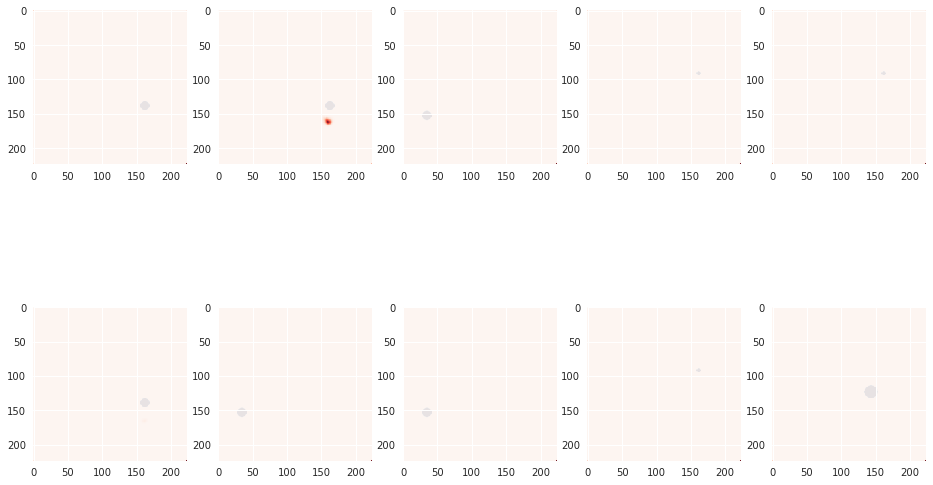

In [17]:
masks_test = np.load('/home/chenxupeng/projects/pr/output/masksTestPredicted_0_1.npy')
fig, ax = plt.subplots(2, 5, figsize=(16,10))
for i in range(5):
    for j in range(2):
        ax[j,i].imshow(masks_test_true[0][100+2*i+j][0],'Blues',alpha = 0.9)
        ax[j,i].imshow(masks_test[100+2*i+j][0],'Reds',alpha = 0.9)
plt.show()

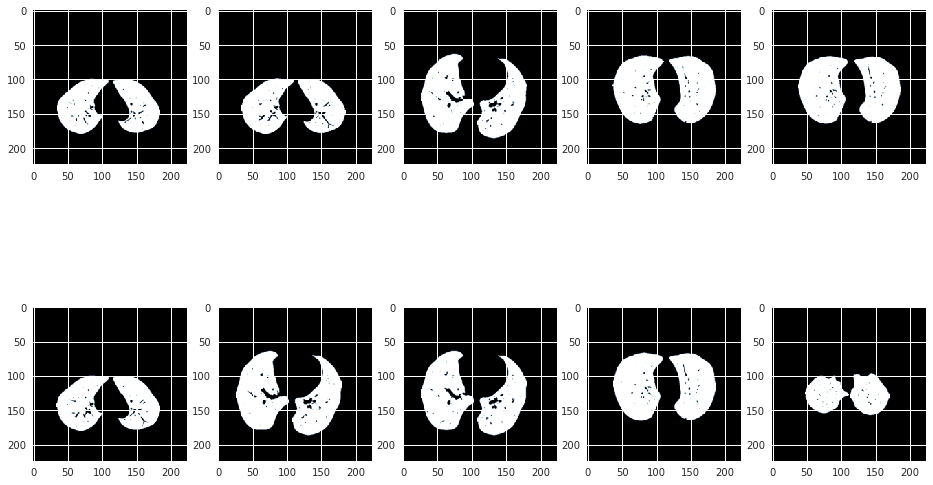

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(16,10))
for i in range(5):
    for j in range(2):
        ax[j,i].imshow(images_test[0][100+2*i+j][0],'bone')
plt.show()

In [ ]:
#先计算一下真实mask的方差，看看合理范围大概在哪里

In [4]:
def sigma( y_pred):
    y, x = np.mgrid[:224, :224]
    m = y_pred /np.sum(y_pred.flatten())
    sigma_x = np.sum((x - np.sum(x*m))**2*m)
    sigma_y = np.sum((y - np.sum(y*m))**2*m)
    return sigma_x*sigma_y

In [5]:
sig = np.ndarray([542*5,1])
for i in range(5):
    for j in range(542):
        sig[542*i+j] = sigma(masks_test_true[i][j][0])

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([  2.07500000e+03,   1.76000000e+02,   6.60000000e+01,
          5.60000000e+01,   5.70000000e+01,   2.50000000e+01,
          3.00000000e+01,   2.70000000e+01,   1.50000000e+01,
          1.90000000e+01,   1.70000000e+01,   2.30000000e+01,
          2.70000000e+01,   1.90000000e+01,   1.20000000e+01,
          0.00000000e+00,   6.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.20000000e+01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   6.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          8.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


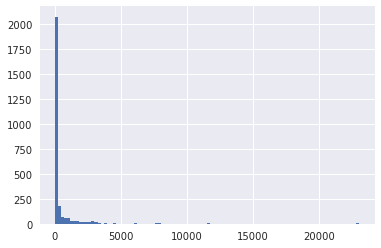

In [8]:
hist(sig.flatten(),bins =100)

In [9]:
print (np.percentile(sig,50))
print (np.percentile(sig,60))
print (np.percentile(sig,70))
print (np.percentile(sig,80))
print (np.percentile(sig,90))

29.3632842363
49.2757821088
113.188122502
305.614170278
1341.89449378


In [ ]:
#用huber loss缓解问题：那就是得想办法让方差很大的时候损失函数不要上升太快
#也许类似huber loss的损失函数会好一些

In [ ]:
def huber_loss(y_true, y_pred, clip_value):
    assert clip_value > 0.

    x = y_true - y_pred
    if np.isinf(clip_value):
        return .5 * K.square(x)

    condition = K.abs(x) < clip_value
    squared_loss = .5 * K.square(x)
    linear_loss = clip_value * (K.abs(x) - .5 * clip_value)
    if K.backend() == 'tensorflow':
        import tensorflow as tf
        if hasattr(tf, 'select'):
            return tf.select(condition, squared_loss, linear_loss)  # condition, true, false
        else:
            return tf.where(condition, squared_loss, linear_loss)  # condition, true, false
    elif K.backend() == 'theano':
        from theano import tensor as T
        return T.switch(condition, squared_loss, linear_loss)
    else:
        raise RuntimeError('Unknown backend "{}".'.format(K.backend()))

In [ ]:
#用augment过的图像来训练？？

In [9]:
with h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/augment_merge') as f:
    images = f['images'][:,:,:,:]
    masks = f['masks'][:,:,:,:]

In [10]:
images.shape

(29130, 1, 512, 512)

In [13]:
from scipy.misc import imresize
def image_resize(image):
    image = imresize(image,(224,224))
    return image
images_= np.ndarray([29130,1,224,224],dtype=np.float32)
masks_= np.ndarray([29130,1,224,224],dtype=np.float32)
for j in tqdm(range(29130)):
    images_[j,0,:,:] =image_resize(images[j,0,:,:])
    masks_[j,0,:,:] =image_resize(masks[j,0,:,:])

  0%|          | 0/29130 [00:00<?, ?it/s]/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 29130/29130 [02:12<00:00, 219.83it/s]


In [14]:
#未归一化，可能因此训练不好。现在逐层归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
def image_resize(image):
    image_ = min_max_scaler.fit_transform(image)
    return image_
imags= np.ndarray([29130,1,224,224],dtype=np.float32)
msks= np.ndarray([29130,1,224,224],dtype=np.float32)
for t in tqdm(range(29130)):
    imags[t,0,:,:] =image_resize(images_[t,0,:,:])
    msks[t,0,:,:] =image_resize(masks_[t,0,:,:])

100%|██████████| 29130/29130 [00:26<00:00, 1105.72it/s]


In [15]:
with h5py.File('preprocess/forunet/augment_merge_224*224_minmax') as f:
    f.create_dataset('images',data = imags)
    f.create_dataset('masks',data = msks)

In [7]:
for i in (1,5):
    print (i)

1
5
